## Dr. Ankur Mali - USF
# Tutorial on Vanishing and Exploding Gradients in RNNs

Consider an RNN where the hidden state is updated at each time step \( t \) as follows: $h_t = \tanh(W_x x_t + W_h h_{t-1} + b_h)$

The loss function $\mathbf{L}$ is computed based on the outputs generated from these hidden states. During backpropagation, the gradient of the loss with respect to the hidden state at an earlier time step \( t \) is computed using the chain rule over multiple time steps.

## Gradient Propagation Through Time

The gradient of the loss with respect to the hidden state at time \( t \) is given by: $ \frac{\partial \mathbf{L}}{\partial h_t} = \sum_{k=t}^{T} \frac{\partial \mathbf{L}}{\partial h_k} \frac{\partial h_k}{\partial h_t}$,

where \( T \) is the total number of time steps (i.e., the sequence length).

The term $\frac{\partial h_k}{\partial h_t}$ represents the influence of the hidden state at time \( t \) on the hidden state at time \( k \) and can be expressed as a product of Jacobians: $\frac{\partial h_k}{\partial h_t} = \prod_{j=t+1}^{k} \frac{\partial h_j}{\partial h_{j-1}}$.

Let each Jacobian be denoted as: $J_j = \frac{\partial h_j}{\partial h_{j-1}}$

Thus, the gradient becomes: $\frac{\partial h_k}{\partial h_t} = J_k \cdot J_{k-1} \cdots J_{t+1}$

## Vanishing Gradients

If the spectral norm (or maximum singular value) of each \( $J_j$ \) is less than 1, i.e.,$\|J_j\| < 1$,

then the product of many such Jacobians will shrink exponentially: $\left\| \frac{\partial h_k}{\partial h_t} \right\| \approx \prod_{j=t+1}^{k} \|J_j\| \ll 1$.

As the gap \( k - t \) increases, the gradients vanish: $\frac{\partial \mathbf{L}}{\partial h_t} \approx \frac{\partial \mathbf{L}}{\partial h_T} \prod_{j=t+1}^{T} \|J_j\| \to 0$.

This is known as the **vanishing gradient problem**.

## Exploding Gradients

Conversely, if the spectral norm of each \( $J_j$ \) is greater than 1, i.e. $\|J_j\| > 1$,

then the product of the Jacobians will grow exponentially:$\left\| \frac{\partial h_k}{\partial h_t} \right\| \approx \prod_{j=t+1}^{k} \|J_j\| \gg 1$.

Thus, as the gap \( k - t \) increases, the gradients explode: $\frac{\partial \mathbf{L}}{\partial h_t} \approx \frac{\partial \mathbf{L}}{\partial h_T} \prod_{j=t+1}^{T} \|J_j\| \to \infty$.

This is known as the **exploding gradient problem**.

## Summary

- **Vanishing Gradients:**  
  When \($\|J_j\| < 1$\), the gradients diminish exponentially:
  $\frac{\partial \mathbf{L}}{\partial h_t} \approx \frac{\partial \mathbf{L}}{\partial h_T} \prod_{j=t+1}^{T} \|J_j\| \to 0$.

- **Exploding Gradients:**  
  When \($\|J_j\| > 1$\), the gradients grow exponentially:$\frac{\partial \mathbf{L}}{\partial h_t} \approx \frac{\partial \mathbf{L}}{\partial h_T} \prod_{j=t+1}^{T} \|J_j\| \to \infty$.

These phenomena pose significant challenges when training RNNs over long sequences and motivate the use of specialized architectures (like LSTM and GRU) and techniques (such as gradient clipping) to mitigate these issues.


## Let's look at normal training

Epoch 1, Gradient Norms: [Array(0.06433792, dtype=float32), Array(0.02503992, dtype=float32), Array(0.01079234, dtype=float32), Array(0.07124725, dtype=float32), Array(0.0251126, dtype=float32)]
Epoch 2, Gradient Norms: [Array(0.0642197, dtype=float32), Array(0.02502197, dtype=float32), Array(0.01073955, dtype=float32), Array(0.07111637, dtype=float32), Array(0.02498973, dtype=float32)]
Epoch 3, Gradient Norms: [Array(0.06410197, dtype=float32), Array(0.02500411, dtype=float32), Array(0.01068701, dtype=float32), Array(0.07098603, dtype=float32), Array(0.02486746, dtype=float32)]
Epoch 4, Gradient Norms: [Array(0.06398474, dtype=float32), Array(0.02498636, dtype=float32), Array(0.01063474, dtype=float32), Array(0.07085619, dtype=float32), Array(0.02474577, dtype=float32)]
Epoch 5, Gradient Norms: [Array(0.063868, dtype=float32), Array(0.0249687, dtype=float32), Array(0.01058273, dtype=float32), Array(0.07072687, dtype=float32), Array(0.02462466, dtype=float32)]
Epoch 6, Gradient Norms: 

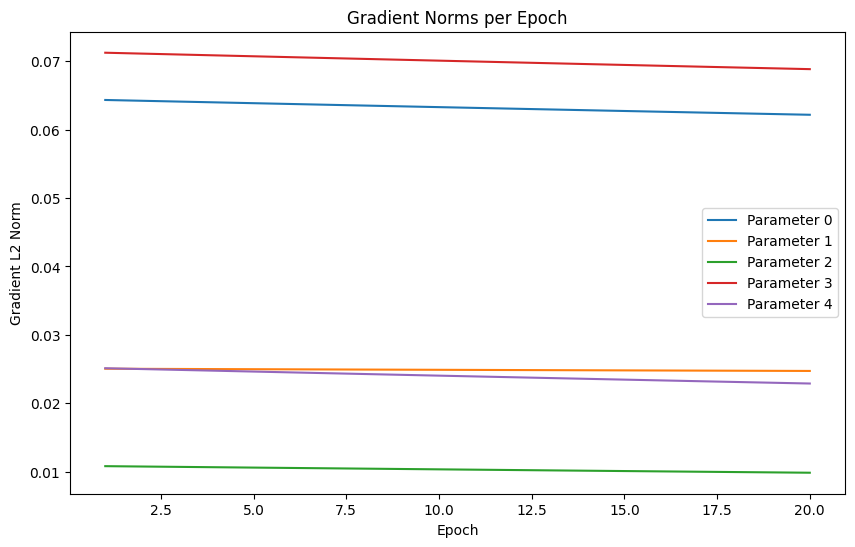

In [1]:
import time
import jax
import jax.numpy as jnp
from jax import lax, random
import numpy as np
import matplotlib.pyplot as plt

# Let's Define the RNN cell and unrolling functions.
# Look at intro to RNN tutorial on github and also your slides
def RNNJAX_unroll(params, X):
    W_x, W_h, b_h, W_out, b_out = params
    batch_size, seq_length, _ = X.shape
    X_t = jnp.swapaxes(X, 0, 1)  # Shape: [seq_length, batch_size, input_size]

    def step_fn(h_prev, x_t):
        h_t = jnp.tanh(jnp.dot(x_t, W_x) + jnp.dot(h_prev, W_h) + b_h)
        out_t = jnp.dot(h_t, W_out) + b_out
        return h_t, out_t

    h0 = jnp.zeros((batch_size, W_h.shape[0]))
    final_h, outs = lax.scan(step_fn, h0, X_t)
    outs = jnp.swapaxes(outs, 0, 1)  # Back to [batch_size, seq_length, input_size]
    return outs

# Initialize the network parameters.
def init_jax_params(key, input_size, hidden_size):
    k1, k2, k3, k4, k5 = jax.random.split(key, 5)
    W_x = 0.1 * jax.random.normal(k1, (input_size, hidden_size))
    W_h = 0.1 * jax.random.normal(k2, (hidden_size, hidden_size))
    b_h = jnp.zeros((hidden_size,))
    W_out = 0.1 * jax.random.normal(k3, (hidden_size, input_size))
    b_out = jnp.zeros((input_size,))
    return (W_x, W_h, b_h, W_out, b_out)

# Define a mean squared error loss.
def loss_fn(params, x, y):
    pred = RNNJAX_unroll(params, x)
    return jnp.mean((pred - y) ** 2)

# Modified training step that computes and returns gradient norms.
@jax.jit
def train_step(params, x, y, lr):
    grads = jax.grad(loss_fn)(params, x, y)
    # Calculate L2 norm for each gradient tensor.
    grad_norms = [jnp.linalg.norm(g) for g in grads]
    new_params = tuple(p - lr * g for p, g in zip(params, grads)) # Simple SGD
    return new_params, grad_norms

# Training loop that logs gradient norms each epoch.
def train_with_gradient_logging(params, X_jax, Y_jax, epochs=10, lr=0.01):
    grad_norms_per_epoch = []
    p = params
    for epoch in range(epochs):
        p, grad_norms = train_step(p, X_jax, Y_jax, lr)
        grad_norms_per_epoch.append(grad_norms)
        print(f"Epoch {epoch+1}, Gradient Norms: {grad_norms}")
    return p, grad_norms_per_epoch

# Benchmark/training function.
def benchmark_with_logging(input_size, hidden_size, X_train, Y_train, epochs=10, lr=0.01):
    key = random.PRNGKey(42)
    params = init_jax_params(key, input_size, hidden_size)
    X_jax = jnp.array(X_train)
    Y_jax = jnp.array(Y_train)

    # Warm-up to compile the JIT-ed function.
    _ = train_step(params, X_jax, Y_jax, lr)

    start_time = time.time()
    p, grad_norms_per_epoch = train_with_gradient_logging(params, X_jax, Y_jax, epochs, lr)
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.4f} seconds")
    return p, grad_norms_per_epoch

# Create dummy data.
input_size = 5
hidden_size = 20
batch_size = 4
seq_length = 50

X_train = np.random.randn(batch_size, seq_length, input_size).astype(np.float32)
Y_train = np.random.randn(batch_size, seq_length, input_size).astype(np.float32)

# Run the training benchmark.
params, grad_norms = benchmark_with_logging(input_size, hidden_size, X_train, Y_train, epochs=20, lr=0.01)

# Convert the list to a NumPy array for plotting.
grad_norms = np.array(grad_norms)  # Shape: (epochs, num_params)
epochs_range = np.arange(1, grad_norms.shape[0] + 1)

# Plot gradient norms per parameter over epochs. (Remember epoch is one pass through entire data)
plt.figure(figsize=(10, 6))
for i in range(grad_norms.shape[1]):
    plt.plot(epochs_range, grad_norms[:, i], label=f'Parameter {i}')
plt.xlabel("Epoch")
plt.ylabel("Gradient L2 Norm")
plt.title("Gradient Norms per Epoch")
plt.legend()
plt.show()


## Vanishing Gradients -- gradients getting very close to zero

Epoch 1, Gradient Norms: [Array(0.03446572, dtype=float32), Array(0.00822044, dtype=float32), Array(0.00085555, dtype=float32), Array(0.03806791, dtype=float32), Array(0.00210777, dtype=float32)]
Epoch 2, Gradient Norms: [Array(0.03439613, dtype=float32), Array(0.00821148, dtype=float32), Array(0.00085153, dtype=float32), Array(0.03798356, dtype=float32), Array(0.00209811, dtype=float32)]
Epoch 3, Gradient Norms: [Array(0.03432674, dtype=float32), Array(0.00820255, dtype=float32), Array(0.00084753, dtype=float32), Array(0.03789954, dtype=float32), Array(0.00208851, dtype=float32)]
Epoch 4, Gradient Norms: [Array(0.03425755, dtype=float32), Array(0.00819365, dtype=float32), Array(0.00084355, dtype=float32), Array(0.03781566, dtype=float32), Array(0.00207895, dtype=float32)]
Epoch 5, Gradient Norms: [Array(0.03418858, dtype=float32), Array(0.00818477, dtype=float32), Array(0.00083959, dtype=float32), Array(0.03773221, dtype=float32), Array(0.00206943, dtype=float32)]
Epoch 6, Gradient No

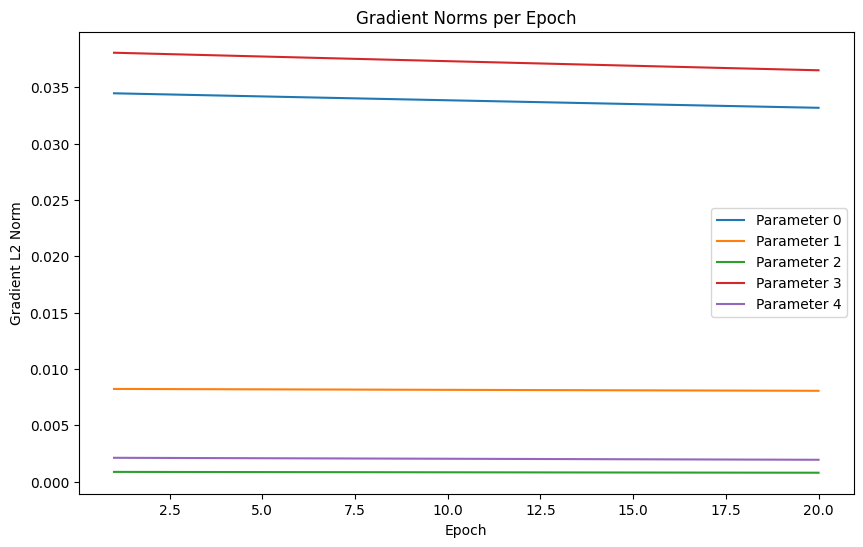

In [2]:
import time
import jax
import jax.numpy as jnp
from jax import lax, random
import numpy as np
import matplotlib.pyplot as plt

# Define the RNN cell and unrolling functions.
def RNNJAX_unroll(params, X):
    W_x, W_h, b_h, W_out, b_out = params
    batch_size, seq_length, _ = X.shape
    X_t = jnp.swapaxes(X, 0, 1)  # Shape: [seq_length, batch_size, input_size]

    def step_fn(h_prev, x_t):
        h_t = jnp.tanh(jnp.dot(x_t, W_x) + jnp.dot(h_prev, W_h) + b_h)
        out_t = jnp.dot(h_t, W_out) + b_out
        return h_t, out_t

    h0 = jnp.zeros((batch_size, W_h.shape[0]))
    final_h, outs = lax.scan(step_fn, h0, X_t)
    outs = jnp.swapaxes(outs, 0, 1)  # Back to [batch_size, seq_length, input_size]
    return outs

# Initialize the network parameters.
def init_jax_params(key, input_size, hidden_size):
    k1, k2, k3, k4, k5 = jax.random.split(key, 5)
    W_x = 0.1 * jax.random.normal(k1, (input_size, hidden_size))
    W_h = 0.1 * jax.random.normal(k2, (hidden_size, hidden_size))
    b_h = jnp.zeros((hidden_size,))
    W_out = 0.1 * jax.random.normal(k3, (hidden_size, input_size))
    b_out = jnp.zeros((input_size,))
    return (W_x, W_h, b_h, W_out, b_out)

# Define a mean squared error loss.
def loss_fn(params, x, y):
    pred = RNNJAX_unroll(params, x)
    return jnp.mean((pred - y) ** 2)

# Modified training step that computes and returns gradient norms.
@jax.jit
def train_step(params, x, y, lr):
    grads = jax.grad(loss_fn)(params, x, y)
    # Calculate L2 norm for each gradient tensor.
    grad_norms = [jnp.linalg.norm(g) for g in grads]
    new_params = tuple(p - lr * g for p, g in zip(params, grads))
    return new_params, grad_norms

# Training loop that logs gradient norms each epoch.
def train_with_gradient_logging(params, X_jax, Y_jax, epochs=10, lr=0.01):
    grad_norms_per_epoch = []
    p = params
    for epoch in range(epochs):
        p, grad_norms = train_step(p, X_jax, Y_jax, lr)
        grad_norms_per_epoch.append(grad_norms)
        print(f"Epoch {epoch+1}, Gradient Norms: {grad_norms}")
    return p, grad_norms_per_epoch

# Benchmark/training function.
def benchmark_with_logging(input_size, hidden_size, X_train, Y_train, epochs=10, lr=0.01):
    key = random.PRNGKey(42)
    params = init_jax_params(key, input_size, hidden_size)
    X_jax = jnp.array(X_train)
    Y_jax = jnp.array(Y_train)

    # Warm-up to compile the JIT-ed function.
    _ = train_step(params, X_jax, Y_jax, lr)

    start_time = time.time()
    p, grad_norms_per_epoch = train_with_gradient_logging(params, X_jax, Y_jax, epochs, lr)
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.4f} seconds")
    return p, grad_norms_per_epoch

# Create dummy data.
input_size = 5
hidden_size = 20
batch_size = 4
seq_length = 50000

X_train = np.random.randn(batch_size, seq_length, input_size).astype(np.float32)
Y_train = np.random.randn(batch_size, seq_length, input_size).astype(np.float32)

# Run the training benchmark.
params, grad_norms = benchmark_with_logging(input_size, hidden_size, X_train, Y_train, epochs=20, lr=0.01)

# Convert the list to a NumPy array for plotting.
grad_norms = np.array(grad_norms)  # Shape: (epochs, num_params)
epochs_range = np.arange(1, grad_norms.shape[0] + 1)

# Plot gradient norms per parameter over epochs.
plt.figure(figsize=(10, 6))
for i in range(grad_norms.shape[1]):
    plt.plot(epochs_range, grad_norms[:, i], label=f'Parameter {i}')
plt.xlabel("Epoch")
plt.ylabel("Gradient L2 Norm")
plt.title("Gradient Norms per Epoch")
plt.legend()
plt.show()


## Exploding gradients

Epoch 1, Gradient Norms: [Array(277222.22, dtype=float32), Array(658945.8, dtype=float32), Array(173851., dtype=float32), Array(29.454868, dtype=float32), Array(0.95458305, dtype=float32)]
Epoch 2, Gradient Norms: [Array(0.00137685, dtype=float32), Array(0.00314831, dtype=float32), Array(0.00070431, dtype=float32), Array(20.457642, dtype=float32), Array(3.7368977, dtype=float32)]
Epoch 3, Gradient Norms: [Array(0.0011134, dtype=float32), Array(0.00211884, dtype=float32), Array(0.0004738, dtype=float32), Array(17.344767, dtype=float32), Array(3.8423069, dtype=float32)]
Epoch 4, Gradient Norms: [Array(0.00106952, dtype=float32), Array(0.00200624, dtype=float32), Array(0.00044861, dtype=float32), Array(18.890976, dtype=float32), Array(3.4755182, dtype=float32)]
Epoch 5, Gradient Norms: [Array(0.00096152, dtype=float32), Array(0.00180272, dtype=float32), Array(0.0004031, dtype=float32), Array(20.7637, dtype=float32), Array(4.2480774, dtype=float32)]
Epoch 6, Gradient Norms: [Array(0.001253

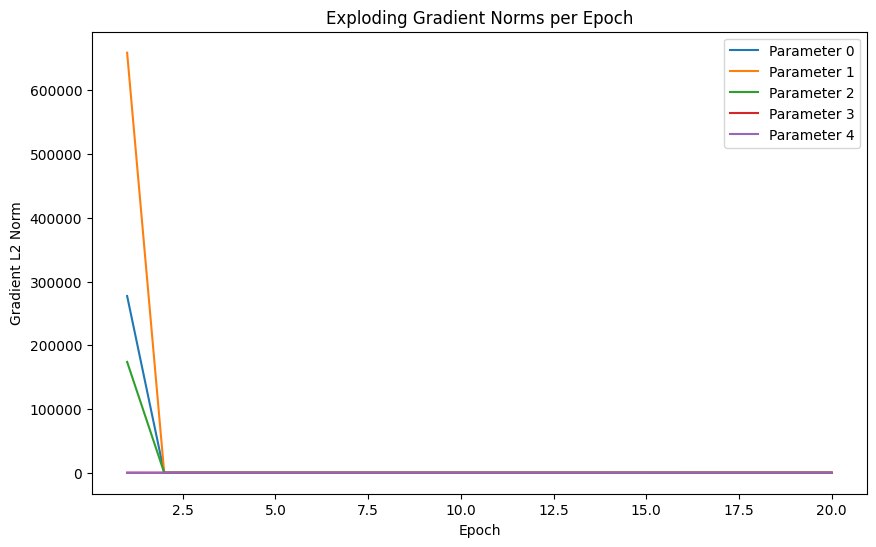

In [3]:
import time
import jax
import jax.numpy as jnp
from jax import lax, random
import numpy as np
import matplotlib.pyplot as plt

# RNN unroll function remains the same.
def RNNJAX_unroll(params, X):
    W_x, W_h, b_h, W_out, b_out = params
    batch_size, seq_length, _ = X.shape
    # Swap axis so that we iterate over time steps
    X_t = jnp.swapaxes(X, 0, 1)  # Shape: [seq_length, batch_size, input_size]

    def step_fn(h_prev, x_t):
        h_t = jnp.tanh(jnp.dot(x_t, W_x) + jnp.dot(h_prev, W_h) + b_h)
        out_t = jnp.dot(h_t, W_out) + b_out
        return h_t, out_t

    h0 = jnp.zeros((batch_size, W_h.shape[0]))
    final_h, outs = lax.scan(step_fn, h0, X_t)
    outs = jnp.swapaxes(outs, 0, 1)  # Back to [batch_size, seq_length, input_size]
    return outs

# Initialize parameters with a high scaling factor to induce instability.
def init_jax_params_exploding(key, input_size, hidden_size):
    k1, k2, k3, k4, k5 = jax.random.split(key, 5)
    scale = 5.0  # Large scaling factor to amplify weights.
    W_x = scale * jax.random.normal(k1, (input_size, hidden_size))
    W_h = scale * jax.random.normal(k2, (hidden_size, hidden_size))
    b_h = jnp.zeros((hidden_size,))
    W_out = scale * jax.random.normal(k3, (hidden_size, input_size))
    b_out = jnp.zeros((input_size,))
    return (W_x, W_h, b_h, W_out, b_out)

# Define a mean squared error loss.
def loss_fn(params, x, y):
    pred = RNNJAX_unroll(params, x)
    return jnp.mean((pred - y) ** 2)

# Modified training step that calculates and returns gradient norms.
@jax.jit
def train_step(params, x, y, lr):
    grads = jax.grad(loss_fn)(params, x, y)
    # Compute L2 norm for each gradient tensor.
    grad_norms = [jnp.linalg.norm(g) for g in grads]
    new_params = tuple(p - lr * g for p, g in zip(params, grads))
    return new_params, grad_norms

# Training loop with logging for exploding gradients.
def train_with_exploding_logging(params, X_jax, Y_jax, epochs=10, lr=1.0):
    grad_norms_per_epoch = []
    p = params
    for epoch in range(epochs):
        p, grad_norms = train_step(p, X_jax, Y_jax, lr)
        grad_norms_per_epoch.append(grad_norms)
        print(f"Epoch {epoch+1}, Gradient Norms: {grad_norms}")
    return p, grad_norms_per_epoch

def benchmark_exploding(input_size, hidden_size, X_train, Y_train, epochs=10, lr=1.0):
    key = random.PRNGKey(42)
    params = init_jax_params_exploding(key, input_size, hidden_size)
    X_jax = jnp.array(X_train)
    Y_jax = jnp.array(Y_train)

    # Warm-up to compile the JIT function.
    _ = train_step(params, X_jax, Y_jax, lr)

    start_time = time.time()
    p, grad_norms_per_epoch = train_with_exploding_logging(params, X_jax, Y_jax, epochs, lr)
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.4f} seconds")
    return p, grad_norms_per_epoch

# Create dummy data.
input_size = 5
hidden_size = 20
batch_size = 4
seq_length = 30  # Shorter sequences here; instability comes from parameter scaling & high LR.

X_train = np.random.randn(batch_size, seq_length, input_size).astype(np.float32)
Y_train = np.random.randn(batch_size, seq_length, input_size).astype(np.float32)

# Run the training benchmark with a high learning rate to promote exploding gradients.
params, grad_norms = benchmark_exploding(input_size, hidden_size, X_train, Y_train, epochs=20, lr=1.0)

# Convert gradient logs to a NumPy array for plotting.
grad_norms = np.array(grad_norms)  # Shape: (epochs, num_params)
epochs_range = np.arange(1, grad_norms.shape[0] + 1)

# Plot the gradient norms per parameter over epochs.
plt.figure(figsize=(10, 6))
for i in range(grad_norms.shape[1]):
    plt.plot(epochs_range, grad_norms[:, i], label=f'Parameter {i}')
plt.xlabel("Epoch")
plt.ylabel("Gradient L2 Norm")
plt.title("Exploding Gradient Norms per Epoch")
plt.legend()
plt.show()


# Replacing Tanh with ReLU

Epoch 1, Gradient Norms: [Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(inf, dtype=float32)]
Epoch 2, Gradient Norms: [Array(0., dtype=float32), Array(nan, dtype=float32), Array(0., dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32)]
Epoch 3, Gradient Norms: [Array(0., dtype=float32), Array(nan, dtype=float32), Array(0., dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32)]
Epoch 4, Gradient Norms: [Array(0., dtype=float32), Array(nan, dtype=float32), Array(0., dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32)]
Epoch 5, Gradient Norms: [Array(0., dtype=float32), Array(nan, dtype=float32), Array(0., dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32)]
Epoch 6, Gradient Norms: [Array(0., dtype=float32), Array(nan, dtype=float32), Array(0., dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32)]
Epoch 7, Gradient Norms: [Array(0., dtype=fl

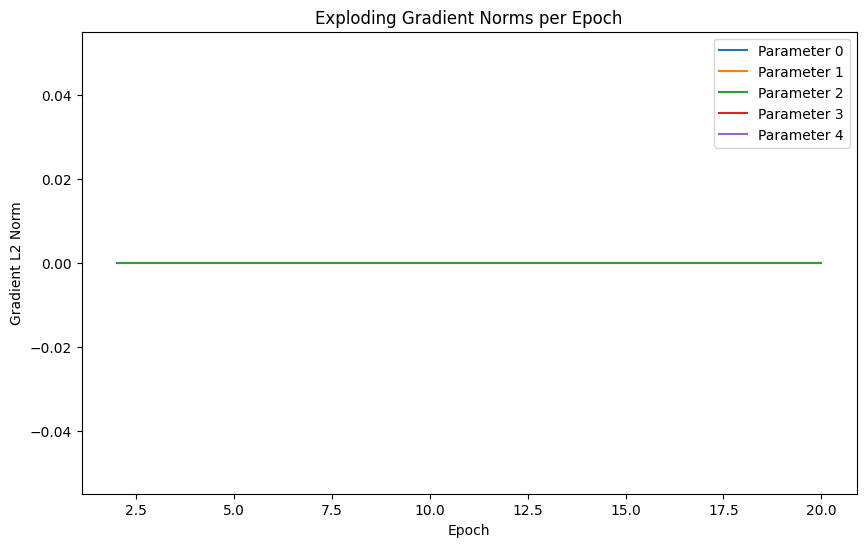

In [4]:
import time
import jax
import jax.numpy as jnp
from jax import lax, random
import numpy as np
import matplotlib.pyplot as plt

# RNN unroll function remains the same.
def RNNJAX_unroll(params, X):
    W_x, W_h, b_h, W_out, b_out = params
    batch_size, seq_length, _ = X.shape
    # Swap axis so that we iterate over time steps
    X_t = jnp.swapaxes(X, 0, 1)  # Shape: [seq_length, batch_size, input_size]

    def step_fn(h_prev, x_t):
        h_t = jax.nn.relu(jnp.dot(x_t, W_x) + jnp.dot(h_prev, W_h) + b_h)
        out_t = jnp.dot(h_t, W_out) + b_out
        return h_t, out_t

    h0 = jnp.zeros((batch_size, W_h.shape[0]))
    final_h, outs = lax.scan(step_fn, h0, X_t)
    outs = jnp.swapaxes(outs, 0, 1)  # Back to [batch_size, seq_length, input_size]
    return outs

# Initialize parameters with a high scaling factor to induce instability.
def init_jax_params_exploding(key, input_size, hidden_size):
    k1, k2, k3, k4, k5 = jax.random.split(key, 5)
    scale = 5.0  # Large scaling factor to amplify weights.
    W_x = scale * jax.random.normal(k1, (input_size, hidden_size))
    W_h = scale * jax.random.normal(k2, (hidden_size, hidden_size))
    b_h = jnp.zeros((hidden_size,))
    W_out = scale * jax.random.normal(k3, (hidden_size, input_size))
    b_out = jnp.zeros((input_size,))
    return (W_x, W_h, b_h, W_out, b_out)

# Define a mean squared error loss.
def loss_fn(params, x, y):
    pred = RNNJAX_unroll(params, x)
    return jnp.mean((pred - y) ** 2)

# Modified training step that calculates and returns gradient norms.
@jax.jit
def train_step(params, x, y, lr):
    grads = jax.grad(loss_fn)(params, x, y)
    # Compute L2 norm for each gradient tensor.
    grad_norms = [jnp.linalg.norm(g) for g in grads]
    new_params = tuple(p - lr * g for p, g in zip(params, grads))
    return new_params, grad_norms

# Training loop with logging for exploding gradients.
def train_with_exploding_logging(params, X_jax, Y_jax, epochs=10, lr=1.0):
    grad_norms_per_epoch = []
    p = params
    for epoch in range(epochs):
        p, grad_norms = train_step(p, X_jax, Y_jax, lr)
        grad_norms_per_epoch.append(grad_norms)
        print(f"Epoch {epoch+1}, Gradient Norms: {grad_norms}")
    return p, grad_norms_per_epoch

def benchmark_exploding(input_size, hidden_size, X_train, Y_train, epochs=10, lr=1.0):
    key = random.PRNGKey(42)
    params = init_jax_params_exploding(key, input_size, hidden_size)
    X_jax = jnp.array(X_train)
    Y_jax = jnp.array(Y_train)

    # Warm-up to compile the JIT function.
    _ = train_step(params, X_jax, Y_jax, lr)

    start_time = time.time()
    p, grad_norms_per_epoch = train_with_exploding_logging(params, X_jax, Y_jax, epochs, lr)
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.4f} seconds")
    return p, grad_norms_per_epoch

# Create dummy data.
input_size = 5
hidden_size = 20
batch_size = 4
seq_length = 30  # Shorter sequences here; instability comes from parameter scaling & high LR.

X_train = np.random.randn(batch_size, seq_length, input_size).astype(np.float32)
Y_train = np.random.randn(batch_size, seq_length, input_size).astype(np.float32)

# Run the training benchmark with a high learning rate to promote exploding gradients.
params, grad_norms = benchmark_exploding(input_size, hidden_size, X_train, Y_train, epochs=20, lr=1.0)

# Convert gradient logs to a NumPy array for plotting.
grad_norms = np.array(grad_norms)  # Shape: (epochs, num_params)
epochs_range = np.arange(1, grad_norms.shape[0] + 1)

# Plot the gradient norms per parameter over epochs.
plt.figure(figsize=(10, 6))
for i in range(grad_norms.shape[1]):
    plt.plot(epochs_range, grad_norms[:, i], label=f'Parameter {i}')
plt.xlabel("Epoch")
plt.ylabel("Gradient L2 Norm")
plt.title("Exploding Gradient Norms per Epoch")
plt.legend()
plt.show()
